In [1]:
from Izh_net import *
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [2]:
class Var_Limb(Net_Limb_connect):

    def __init__(self, **kwargs):
        """
        Реализация соединения в единую систему 
        именованые ардгументы:

        Network - объект класса Network
        Limb - объект класса Afferented_Limb или Simple_Afferented_Limb
        """
        super().__init__(**kwargs)
        self.names = {
            "neurons": self.net.names,
            "muscles": ["Flexor", "Extensor"],
            "afferents": [
                # Flexor sensors
                "Ia_Flex",
                "II_Flex", 
                "Ib_Flex",
                # Extensor sensors
                "Ia_Ext",
                "II_Ext",
                "Ib_Ext"
            ]
            
        }

    # Vaiances of network params

    # inherit from NameNetwork
    def set_weights_by_names(self, *args, **kwargs):
        """
        Change weight of connections by names of neurons
        inherit from NameNetwork

        exec method of self.net.set_weights_by_names
        Params:
        source_name(str)
        target_name(str)
        new_weight(float)
        """
        try:
            self.net.set_weights_by_names(*args, **kwargs)
        except AttributeError:
            print("Ошибка: такого метода нет!")

    @property
    def SynapticWeights(self):
        return self.net.W

    @property
    def SynapticRelaxation(self):
        return self.net.tau_syn

    @property
    def AfferentWeights(self):
        return self.net.Q_aff

    def set_afferents_by_names(            
            self,
            afferent_name,
            neuron_name,
            new_weight):
        """
        Change weight of connections by names of afferents and neurons

        Params:
        source_name(str)
        target_name(str)
        new_weight(float)
        """
        try:
            afferent_idx = self.names["afferents"].index(afferent_name)
            neuron_idx = self.names["neurons"].index(neuron_name)
            self.net.Q_aff[afferent_idx, neuron_idx] = new_weight
            return True
        except ValueError:
            return False

    def set_muscle_params(self,
                          muscle_name,
                          **params
                         ):
        if muscle_name == "Flexor":
            self.Limb.Flexor.set_params(**params)
        elif muscle_name == "Extensor":
            self.Limb.Extensor.set_params(**params)
        else:
            print(f"Мышца с именем \"{muscle_name}\" не найдена...")
            

    
    
    

(4, 2)
['CH', 'FS', 'CH', 'FS']
[0.001 0.1   0.001 0.1  ] [0.2 0.2 0.2 0.2] [-50. -65. -50. -65.] [2. 2. 2. 2.]
[[0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.05]]
[[ 0.   0.   0.  -1.1]
 [ 1.7  0.   0.   0. ]
 [ 0.  -1.1  0.   0. ]
 [ 0.   0.   1.7  0. ]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

____________________________
set_afferents_by_names TEST
OK

____________________________
set_weights_by_names TEST
OK

____________________________
set_muscle_params TEST
OK

____________________________
simulation test


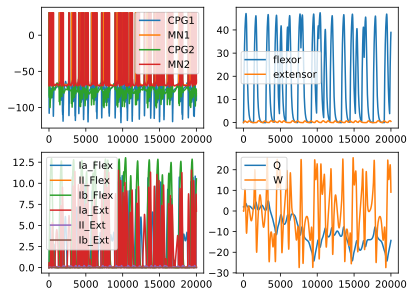

In [3]:
def test_Var_Limb():
    Q_app = np.array([
            [1, 0],
            [0, 0],
            [0, 1],
            [0, 0]
        ])
    print(Q_app.shape)
    Q_aff = 1*np.random.rand(4, 6)
    P = np.array([
            [1, 0, 0, 0],
            [0, 0, 1, 0]
        ])
    names = ["CPG1", "MN1", "CPG2", "MN2"]
    types = ['CH', 'FS', 'CH', 'FS']
    print(types)
    # Create params' array from neurons
    A, B, C, D = types2params(types)
    A[0] = 0.001
    A[2] = 0.001
    print(A, B, C, D)
    net = Izhikevich_IO_Network(input_size = 2, output_size = 2, 
                                afferent_size = 6,
                                N=4, Q_app = Q_app,
                                names = names,
                                Q_aff = Q_aff , P = P)
    
    net.set_params(a=A, b=B, c=C, d=D) 
    # Neuron_weigths
    W = [
            [0, 0, 0, -1.1],
            [1.7, 0, 0, 0],
            [0, -1.1, 0, 0],
            [0, 0, 1.7, 0]
        ]
    
    N=4
    net.M = np.ones((N, N))
    net.set_weights(W)
    tau_syn = 20*np.ones((N, N))
    net.set_synaptic_relax_constant(tau_syn)
    print(net.tau_syn)
    print(net.W)
    print(net.M)
    
    # Limb settings
    flexor = SimpleAdaptedMuscle(w = 0.5, N=2)
    extensor = SimpleAdaptedMuscle(w = 0.4, N=2)
    Limb = OneDOFLimb(q0=np.pi/2+0.4, b=0.001, a1 = 0.4,
                      a2= 0.05, m=0.3, l=0.3)
    AL = Afferented_Limb(
                Limb = Limb,
                Flexor = flexor,
                Extensor = extensor
            )

    # Creating all system
    sys = Var_Limb(Network=net,
                           Limb = AL)

    print("")
    print("____________________________")
    print("set_afferents_by_names TEST")
    sys.set_afferents_by_names("Ia_Flex", "CPG1", 1)
    print("OK")

    print("")
    print("____________________________")
    print("set_weights_by_names TEST")
    sys.set_weights_by_names("CPG1", "MN1", 0.4)
    print("OK")

    print("")
    print("____________________________")
    print("set_muscle_params TEST")
    sys.set_muscle_params("Flexor", A = 0.4)
    print("OK")



    print('')
    print("____________________________")
    print("simulation test")
    T = np.linspace(0, 20000, 50000)
    I = np.zeros(2)
    I[0] = 5
    I[1] = 5
    input = lambda t: (I)
    V = np.zeros((len(T), N))
    F_flex = np.zeros(len(T))
    F_ext = np.zeros(len(T))
    Afferents = np.zeros((len(T), 6))
    Q = np.zeros(len(T))
    W = np.zeros(len(T))
    dt = T[1] - T[0]
    for i, t in enumerate(T):
        V[i] = sys.net.V_prev
        F_flex[i] = sys.F_flex
        F_ext[i] = sys.F_ext
        Afferents[i] = sys.Limb.output
        Q[i] = sys.q
        W[i] = sys.w
        sys.step(dt = dt, Iapp = input(t))

    plt.figure()
    plt.subplot(221)
     
    for i in range(N):
        plt.plot(T, V[:, i], label=f"{sys.net.names[i]}")
    plt.legend()

    plt.subplot(222)
    plt.plot(T, F_flex, label='flexor')
    plt.plot(T, F_ext, label='extensor')
    plt.legend()

    plt.subplot(223)
    aff_types = sys.names['afferents']
    for i in range(6):
        plt.plot(T, Afferents[:, i], label=aff_types[i])
    plt.legend()

    plt.subplot(224)
    plt.plot(T, Q, label="Q")
    plt.plot(T, W, label='W')
    plt.legend()
    plt.show()

test_Var_Limb()

In [5]:
help(SimpleAdaptedMuscle)

Help on class SimpleAdaptedMuscle in module Izh_net:

class SimpleAdaptedMuscle(builtins.object)
 |  SimpleAdaptedMuscle(**kwargs)
 |
 |  Equetions:
 |  -- Muscle synapse
 |  dCn(t)/dt + Cn(t)/tau_c = u(t), u - input
 |  x(t) = Cn^m/(Cn^m + k^m)
 |  -- Output Force
 |  dF(t)/dt + F(t)/tau_1 = Ax(t)
 |
 |  Methods defined here:
 |
 |  __init__(self, **kwargs)
 |      Arguments:
 |      w - weight of neuron-muscle synapse
 |
 |  set_init_conditions(self)
 |
 |  set_params(self, **kwargs)
 |
 |  step(self, dt=0.1, u=0)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object

